In [9]:
from numpy.fft import fft, ifft, fft2, ifft2, ifftshift, fftshift
import math
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np


[0, 512, 0, 512]


Text(0, 0.5, 'y')

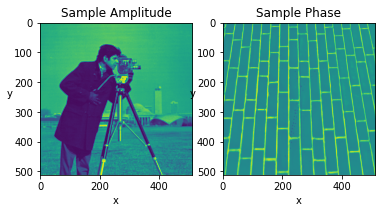

In [10]:
#creating the input amplitude/phase objects
from skimage import data
objectAmplitude = np.double(data.camera())
phase = np.double(data.brick())
phase = np.pi * phase / np.max(phase)
obj = objectAmplitude * np.exp(1j * phase)
fig, ax = plt.subplots(1,2)

N, M = obj.shape

dims=[0,N,0,M]
print(dims)
amplitude_img = ax[0].imshow(np.abs(obj))
phase_img = ax[1].imshow(np.angle(obj))

ax[0].set_title('Sample Amplitude')
ax[1].set_title('Sample Phase')

ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation = 0)

ax[1].set_xlabel('x')
ax[1].set_ylabel('y', rotation = 0)

In [11]:
#define LED specifications
arraysize = 15
LEDgap = 4 #4mm between adj LED's
LEDheight = 90 # 90mm between LED and sample

# 1-D x and y position vectors
xloc = np.arange(-arraysize*LEDgap//2,arraysize*LEDgap//2,LEDgap)+(LEDgap+1)//2+1.5
yloc = np.arange(-arraysize*LEDgap//2,arraysize*LEDgap//2,LEDgap)+(LEDgap+1)//2

#2x2 coordinate matrices for x and y
#ex. X[0] represents all the x values at y=0
#ex. Y[0] represents all the y values at x=0
#more information here: https://www.geeksforgeeks.org/numpy-meshgrid-function/

X,Y = np.meshgrid(xloc,yloc)
X = X.flatten()
Y = Y.flatten()
    
kx_relative = -np.sin(np.arctan(X/LEDheight));
ky_relative = -np.sin(np.arctan(Y/LEDheight))



Text(0.5, 1.0, 'Cameraman Image')

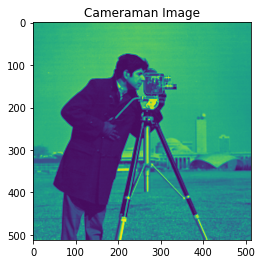

In [12]:
from skimage import data
fig, ax = plt.subplots()
im_cameraman = data.camera()
ax.imshow(im_cameraman)
ax.set_title('Cameraman Image')

M512
128


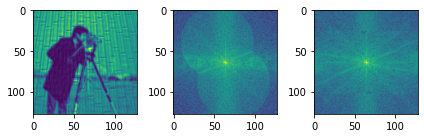

In [13]:
waveLength = .63e-6
k0 = 2*np.pi/waveLength
spsize = 2.75e-6              #camerapixelsize/magnification pixel size
scaling_factor = 4              
psize = spsize/scaling_factor #hi-res pixel size (smaller than the sensor pixel size)
NA= 0.08

[m,n] = obj.shape          #image size of the high resolution object
print("M" + str(m))
m1 = m//(scaling_factor)
print(m1)
n1 = n//(scaling_factor)        #image size of the final output (low res)
imSeqLowRes = np.zeros([m1,n1, arraysize**2]) #image sequence of low-resolution images. 225 (128x128) images for 225 LEDs!
imSeqShifts = np.zeros([m1,n1,arraysize**2])
kx = k0 * (kx_relative)
ky = k0 * ky_relative
dkx = 2*np.pi/(psize * n)
dky = 2*np.pi/(psize * m)
cutoffFrequency = NA*k0
kmax= np.pi/spsize

kx_lowres = np.linspace(-kmax, kmax, n1,endpoint=False)
ky_lowres = np.linspace(-kmax, kmax, m1,endpoint=False)
kxm, kym = np.meshgrid(kx_lowres, ky_lowres)
CTF = ((kxm**2 + kym **2) < cutoffFrequency ** 2)
objectFT = fftshift(fft2(obj))



for i in range(arraysize**2):
    kxc = np.int((n)/2 + kx[i]/dkx)
    kyc = np.int((m)/2 + ky[i]/dky)
    kyl = np.int(kyc - (m1)/2)
    kyh = np.int(kyc + (m1)/2)
    kxl = np.int(kxc - (n1)/2)
    kxh = np.int(kxc + (n1)/2)
    imSeqLowFT = ((scaling_factor) ** 2 * objectFT[kyl:kyh, kxl:kxh])
    imSeqLowFT_mask = ((scaling_factor) ** 2 * objectFT[kyl:kyh, kxl:kxh]) * CTF

    imSeqLowRes[:,:,i] = np.abs(ifft2(ifftshift(imSeqLowFT_mask)))
    imSeqShifts[:,:,i]= np.abs(ifft2(ifftshift(imSeqLowFT)))

#print(imSeqLowRes)
i = 127

fig, ax = plt.subplots(1,3)
him = ax[0].imshow(imSeqLowRes[:,:,i])

him = ax[1].imshow(np.abs(fftshift(fft2(imSeqLowRes[:,:,i]))), norm=colors.LogNorm() )
 
him = ax[2].imshow(np.abs(fftshift(fft2(imSeqShifts[:,:,i]))), norm=colors.LogNorm() )
plt.tight_layout()




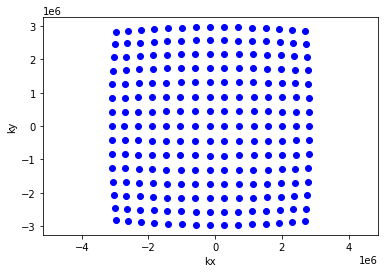

In [14]:
theta = np.arctan2(Y,X)
kx_relative = np.cos(theta) * -np.sin(np.arctan(np.sqrt(X**2+Y**2)/LEDheight));
ky_relative = np.sin(theta) * -np.sin(np.arctan(np.sqrt(X**2+Y**2)/LEDheight))

kx_relative = np.cos(theta) * -np.sin(np.arctan(np.sqrt(X**2+Y**2)/LEDheight));
ky_relative = np.sin(theta) * -np.sin(np.arctan(np.sqrt(X**2+Y**2)/LEDheight))


kx = k0 * kx_relative
ky = k0 * ky_relative
fig, ax =plt.subplots(1,1)
ax.axis('equal')
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.plot(kx, ky, 'bo')


In [15]:
from math import sqrt

def gradientImage(im):
    newim = np.zeros((len(im), len(im[0])))
    gr2 = np.zeros((len(newim), len(newim[0])))
    print(newim.shape)
    for i in range(1,len(im)-1):
        for j in range(1,len(im[0])-1):
            grady = im.item(i,j+1) - im.item(i,j-1)
            gradx =im.item(i+1,j)-im.item(i-1,j)
            newim[i,j] = sqrt(gradx**2 + grady**2)
    for i in range(1,len(newim)-1):
        for j in range(1,len(newim[0])-1):
            grady = newim.item(i,j+1) - newim.item(i,j-1)
            gradx =newim.item(i+1,j)-newim.item(i-1,j)
            gr2[i,j] = sqrt(gradx**2 + grady**2)
    return newim,gr2
    
  

    
    
            

In [16]:
from scipy.ndimage.filters import gaussian_filter
#plots intensity vs r value of image derivative and second derivative values (image gradients)
#input: low-resolution brightfield image
def findEdge(im):
    im = np.log10(np.abs(fftshift(fft2(np.double(im))))) #obtain fourier spectrum of image
    im_normalized = im/np.mean(im) #divide out the mean spectrum
    im_blurred = gaussian_filter(im_normalized, sigma=2) #convolving with the Gaussian Kernel with std.dev = 2 pixels
    im_gradient = gradientImage(im_blurred)[0]
    im_gradient2 = gradientImage(im_blurred)[1]
    fig, ax = plt.subplots(1,4)
    plt.subplots_adjust(left=None, bottom=None, right=3, top=None, wspace=None, hspace=None)   
    him0 = ax[0].imshow(np.abs(im))
    him1 = ax[1].imshow(np.abs(im_normalized))
    him2 = ax[2].imshow(np.abs(im_blurred))
    him3 = ax[3].imshow(np.abs(im_gradient))

    
    ax[0].set_title("Low-Res Fourier Spectrum")
    ax[1].set_title("Fourier Spectrum Divided by Mean")
    ax[2].set_title("Mean spectrum convolved with gaussian kernel!")
    ax[3].set_title("Gradient (1st order)")





    
    

(128, 128)
(128, 128)


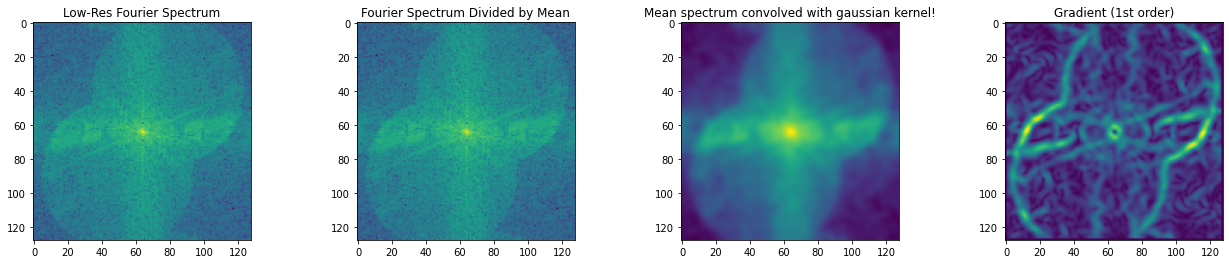

In [17]:
findEdge(imSeqLowRes[:,:,126])

In [18]:
def gseq(arraysize): 
    #function to return the sequence of reconstruction images
    n = (arraysize-1)/2
    sequence = np.zeros([2, (arraysize**2)])
    sequence[0,0] = n; sequence[1,0] = n
    dx=1;dy=-1;stepx=1;stepy=-1
    counter=0;direction=1
    for i in range(1,int(arraysize**2)):
        counter+=1
        if(direction ==1):
            sequence[0,i] = sequence[0,i-1]+dx
            sequence[1,i] = sequence[1,i-1]
            if (counter==abs(stepx)):
                counter = 0; direction *= -1;
                dx*=-1; stepx*=-1;
                if stepx > 0:
                    stepx+=1
                else:
                    stepx-=1
        else:
            sequence[0,i] = sequence[0,i-1]
            sequence[1,i] = sequence[1,i-1]+dy
            if counter==np.abs(stepy):
                counter = 0; direction *= -1;
                dy*=-1; stepy*=-1;
                if stepy > 0:
                    stepy+=1
                else:
                    stepy-=1
    seq = (sequence[0,:]) * arraysize + sequence[1,:]
    return seq.astype(np.int)

In [19]:
print(gseq(arraysize))

[112 127 126 111  96  97  98 113 128 143 142 141 140 125 110  95  80  81
  82  83  84  99 114 129 144 159 158 157 156 155 154 139 124 109  94  79
  64  65  66  67  68  69  70  85 100 115 130 145 160 175 174 173 172 171
 170 169 168 153 138 123 108  93  78  63  48  49  50  51  52  53  54  55
  56  71  86 101 116 131 146 161 176 191 190 189 188 187 186 185 184 183
 182 167 152 137 122 107  92  77  62  47  32  33  34  35  36  37  38  39
  40  41  42  57  72  87 102 117 132 147 162 177 192 207 206 205 204 203
 202 201 200 199 198 197 196 181 166 151 136 121 106  91  76  61  46  31
  16  17  18  19  20  21  22  23  24  25  26  27  28  43  58  73  88 103
 118 133 148 163 178 193 208 223 222 221 220 219 218 217 216 215 214 213
 212 211 210 195 180 165 150 135 120 105  90  75  60  45  30  15   0   1
   2   3   4   5   6   7   8   9  10  11  12  13  14  29  44  59  74  89
 104 119 134 149 164 179 194 209 224]


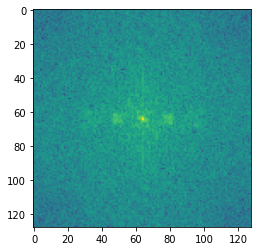

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams['animation.embed_limit'] = 2**128

from IPython.display import HTML

fig, ax = plt.subplots()

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(arraysize**2):
    im = ax.imshow(np.abs(fftshift(fft2(imSeqLowRes[:,:,i]))),animated=True,norm=colors.LogNorm())
    if i == 0:
        ax.imshow(imSeqLowRes[:,:,0])  # show an initial one first
    ims.append([im])

anim = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=1000)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

HTML(anim.to_html5_video())


In [21]:
def rms(og, k):
    diff = og - k
    return np.sum(np.sqrt(np.mean(diff**2)))

In [22]:

def phaseRetrieval(iterations, scaling_factor, kx, ky, dkx, dky, seq):
#recovering the high res image!
    seq = gseq(arraysize) #going from the 113 image to the 225 image
    objectRecover = np.ones([m,n])
    objectRecoverFT = fftshift(fft2(objectRecover))
    for i in range(iterations):
        for j in range(arraysize **2):
            limg = seq[j]
            
            kxc = np.round(n/2 +kx[limg]/dkx)
            kyc = np.round(m/2 +ky[limg]/dky)
            kyl = np.round(kyc - (m1)/2); kyh = np.round(kyc + (m1)/2)
            kxl = np.round(kxc - (n1)/2); kxh=np.round(kxc + (n1)/2)
            kxl = int(kxl)
            kyl = int(kyl)
            kxh = int(kxh)
            kyh = int(kyh)

            lowResFT = (scaling_factor)**2 * objectRecoverFT[kyl:kyh, kxl:kxh] * CTF
            im_lowRes = ifft2(ifftshift(lowResFT));
            im_lowRes = (1/scaling_factor)**2 * imSeqLowRes[:,:,limg] * np.exp(1j * np.angle(im_lowRes))
            lowResFT = fftshift(fft2(im_lowRes)) * CTF
            objectRecoverFT[kyl:kyh,kxl:kxh] = (1-CTF) * objectRecoverFT[kyl:kyh,kxl:kxh] + lowResFT
    objectRecover = ifft2(ifftshift(objectRecoverFT))
    return (objectRecover,objectRecoverFT)
objectRecover = phaseRetrieval(5, scaling_factor,kx,ky,dkx,dky,gseq(arraysize**2))
OR = objectRecover[0]
OFT = objectRecover[1]
objectRecover2 = phaseRetrieval(1, scaling_factor,kx,ky,dkx,dky,gseq(arraysize**2))[0]
print(rms(np.angle(obj), np.angle(OR)))
print(rms(np.angle(obj), np.angle(objectRecover2)))



        

1.6808342929504367
1.6854969794767636


(512, 512)


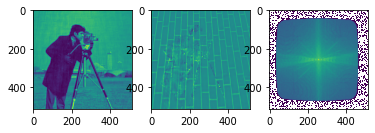

In [23]:
fig, ax = plt.subplots(1, 3)
him0 = ax[0].imshow(np.abs(OR))
him1 = ax[1].imshow(np.angle(objectRecover2))
him2 = ax[2].imshow(np.abs(OFT), norm = colors.LogNorm())
print(np.angle(OR).shape)


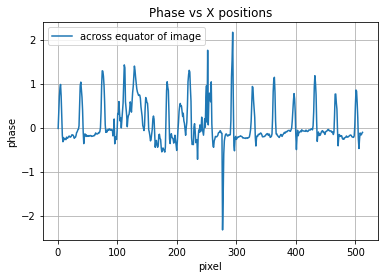

In [24]:
xval = np.linspace(1,512,512)
yval = np.array(np.angle(OR[256]))
fig, ax = plt.subplots()

ax.set(xlabel='pixel', ylabel='phase',
       title='Phase vs X positions')
ax.plot(xval, yval,label="across equator of image")

ax.grid()
ax.legend()


plt.show()


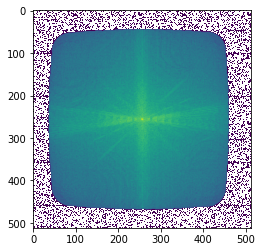

In [25]:


# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)


#recovering the high res image!
fig, ax = plt.subplots()

ims_object = []
ims_object_ft = []

seq = gseq(arraysize) #going from the 113 image to the 225 image
objectRecover = np.ones([m,n])
objectRecoverFT = fftshift(fft2(objectRecover))
for i in range(1):
    for j in range(arraysize **2):
        limg = seq[j]
        kxc = np.round(n/2 +kx[limg]/dkx)
        kyc = np.round(m/2 +ky[limg]/dky)
        kyl = np.round(kyc - (m1)/2); kyh = np.round(kyc + (m1)/2)
        kxl = np.round(kxc - (n1)/2); kxh=np.round(kxc + (n1)/2)
        kxl = int(kxl)
        kyl = int(kyl)
        kxh = int(kxh)
        kyh = int(kyh)

        #select a small sub-region of the initial guess's fourier spectrum, equivalent to a low-pass filter
        #of the coherent imaging system
        lowResFT = (scaling_factor)**2 * objectRecoverFT[kyl:kyh, kxl:kxh] * CTF 
        #apply the inverse fourier transform to generate a low resolution target image 
        im_lowRes = ifft2(ifftshift(lowResFT)); 
        im_lowRes = (1/scaling_factor)**2 * imSeqLowRes[:,:,limg] * np.exp(1j * np.angle(im_lowRes))
        lowResFT = fftshift(fft2(im_lowRes)) * CTF
        objectRecoverFT[kyl:kyh,kxl:kxh] = (1-CTF) * objectRecoverFT[kyl:kyh,kxl:kxh] + lowResFT
        im = ax.imshow(np.abs(objectRecoverFT),animated=True,norm = colors.LogNorm())
        #im = ax.imshow(np.abs(ifft2(ifftshift(objectRecoverFT))))

        ims_object_ft.append([im])
        #ims_object.append(ifft2(ifftshift(objectRecoverFT)))
objectRecover = ifft2(ifftshift(objectRecoverFT))

anim = animation.ArtistAnimation(fig, ims_object_ft, interval=10, blit=True,repeat_delay=1000)
anim2 = animation.ArtistAnimation(fig, ims_object_ft, interval=200, blit=True,  repeat_delay=1000)
HTML(anim.to_html5_video())
HTML(anim2.to_html5_video())





In [26]:
z =10e-5
kzm = np.sqrt(k0**2-kxm**2-kym**2)
pupil = np.exp(1j * z * np.real(kzm)) * np.exp(-np.abs(z)* np.abs(np.imag(kzm)));
CTF_withaberration = pupil * CTF

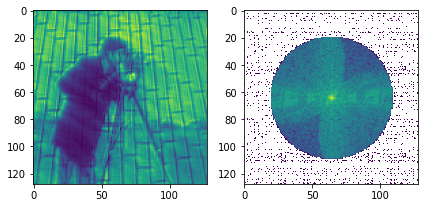

In [27]:
for i in range(arraysize**2):
    kxc = np.int((n)/2 + kx[i]/dkx)
    kyc = np.int((m)/2 + ky[i]/dky)
    kyl = np.int(kyc - (m1)/2)
    kyh = np.int(kyc + (m1)/2)
    kxl = np.int(kxc - (n1)/2)
    kxh = np.int(kxc + (n1)/2)
    imSeqLowFT = ((scaling_factor) ** 2 * objectFT[kyl:kyh, kxl:kxh]) * CTF_withaberration
    imSeqLowRes[:,:,i] = np.abs(ifft2(ifftshift(imSeqLowFT)))
#print(imSeqLowRes)
i = 128

fig, ax = plt.subplots(1,2)
him = ax[0].imshow(imSeqLowRes[:,:,i])

him = ax[1].imshow(np.abs(fftshift(fft2(imSeqLowRes[:,:,i])) * CTF_withaberration), norm=colors.LogNorm() )

plt.tight_layout()

In [28]:
def phaseRetrieval2(iterations, scaling_factor, kx, ky, dkx, dky, seq):
#recovering the high res image!
    seq = gseq(arraysize) #going from the 113 image to the 225 image
    objectRecover = np.ones([m,n])
    objectRecoverFT = fftshift(fft2(objectRecover))
    for i in range(iterations):
        for j in range(arraysize **2):
            limg = seq[j]
            
            kxc = np.round(n/2 +kx[limg]/dkx)
            kyc = np.round(m/2 +ky[limg]/dky)
            kyl = np.round(kyc - (m1)/2); kyh = np.round(kyc + (m1)/2)
            kxl = np.round(kxc - (n1)/2); kxh=np.round(kxc + (n1)/2)
            kxl = int(kxl)
            kyl = int(kyl)
            kxh = int(kxh)
            kyh = int(kyh)

            lowResFT = (scaling_factor)**2 * objectRecoverFT[kyl:kyh, kxl:kxh] * CTF * pupil
            im_lowRes = ifft2(ifftshift(lowResFT));
            im_lowRes = (1/scaling_factor)**2 * imSeqLowRes[:,:,limg] * np.exp(1j * np.angle(im_lowRes))
            lowResFT = fftshift(fft2(im_lowRes)) * CTF * 1/pupil
            objectRecoverFT[kyl:kyh,kxl:kxh] = (1-CTF) * objectRecoverFT[kyl:kyh,kxl:kxh] + lowResFT
    objectRecover = ifft2(ifftshift(objectRecoverFT))
    return (objectRecover,objectRecoverFT)
objectRecoverA = phaseRetrieval2(5, scaling_factor,kx,ky,dkx,dky,gseq(arraysize**2))
ORA = objectRecoverA[0]
OFTA = objectRecoverA[1]
print(rms(np.angle(obj), np.angle(OR)))
print(rms(np.angle(obj), np.angle(objectRecover2)))







1.6808342929504367
1.6854969794767636


(0.7544418508670031-2.661983754581816j)


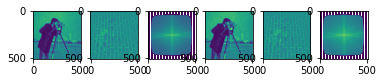

In [29]:
fig, ax = plt.subplots(1, 6)
him0 = ax[0].imshow(np.abs(OR))
him1 = ax[1].imshow(np.angle(OR))
him2 = ax[2].imshow(np.abs(OFT), norm = colors.LogNorm())
him3 = ax[3].imshow(np.abs(ORA))
him4 = ax[4].imshow(np.angle(ORA))
him5 = ax[5].imshow(np.abs(OFTA), norm = colors.LogNorm())
print(rms(OR,ORA))

In [30]:
def phaseRetrieval3(iterations, scaling_factor, kx, ky, dkx, dky, seq):
#recovering the high res image!
    seq = gseq(arraysize) #going from the 113 image to the 225 image
    objectRecover = np.ones([m,n])
    objectRecoverFT = fftshift(fft2(objectRecover))
    converIndex = np.zeros([iterations])
    for i in range(iterations):
        for j in range(arraysize **2):
            limg = seq[j]
            
            kxc = np.round(n/2 +kx[limg]/dkx)
            kyc = np.round(m/2 +ky[limg]/dky)
            kyl = np.round(kyc - (m1)/2); kyh = np.round(kyc + (m1)/2)
            kxl = np.round(kxc - (n1)/2); kxh=np.round(kxc + (n1)/2)
            kxl = int(kxl)
            kyl = int(kyl)
            kxh = int(kxh)
            kyh = int(kyh)

            lowResFT = (scaling_factor)**2 * objectRecoverFT[kyl:kyh, kxl:kxh] * CTF * pupil
            im_lowRes = ifft2(ifftshift(lowResFT));
            converIndex[i] = converIndex[i] + np.mean(np.mean(np.abs(im_lowRes))) / np.sum(np.sum(np.abs(im_lowRes-imSeqLowRes[:,:,limg])))

            im_lowRes = (1/scaling_factor)**2 * imSeqLowRes[:,:,limg] * np.exp(1j * np.angle(im_lowRes))
            
            lowResFT = fftshift(fft2(im_lowRes)) * CTF * 1/pupil
            objectRecoverFT[kyl:kyh,kxl:kxh] = (1-CTF) * objectRecoverFT[kyl:kyh,kxl:kxh] + lowResFT
    objectRecover = ifft2(ifftshift(objectRecoverFT))
    return (objectRecover,objectRecoverFT, converIndex)

In [31]:
stuff = phaseRetrieval3(5, scaling_factor,kx,ky,dkx,dky,gseq(arraysize**2))
ORA = stuff[0]
OFTA = stuff[1]
convIndex = stuff[2]



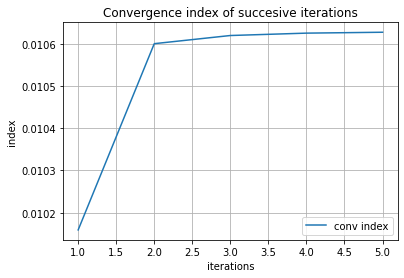

In [32]:
xval = np.linspace(1,5,5)
yval = np.array(convIndex)
fig, ax = plt.subplots()

ax.set(xlabel='iterations', ylabel='index',
       title='Convergence index of succesive iterations')
ax.plot(xval, yval,label="conv index")

ax.grid()
ax.legend()


plt.show()


In [33]:
def phaseRetrieval4(iterations, scaling_factor, kx, ky, dkx, dky, seq):
#phase Retrieval with EPRY (embedded pupil function recovery)
    seq = gseq(arraysize) #going from the 113 image to the 225 image
    objectRecover = np.ones([m,n])
    objectRecoverFT = fftshift(fft2(objectRecover))
    pupil = 1
    for i in range(iterations):
        #print("loop ", i)
        #print(pupil)
        for j in range(arraysize **2):
            limg = seq[j]
            
            kxc = np.round(n/2 +kx[limg]/dkx)
            kyc = np.round(m/2 +ky[limg]/dky)
            kyl = np.round(kyc - (m1)/2); kyh = np.round(kyc + (m1)/2)
            kxl = np.round(kxc - (n1)/2); kxh=np.round(kxc + (n1)/2)
            kxl = int(kxl)
            kyl = int(kyl)
            kxh = int(kxh)
            kyh = int(kyh)

            lowResFT_1 = (scaling_factor)**2 * objectRecoverFT[kyl:kyh, kxl:kxh] * CTF * pupil
            im_lowRes = ifft2(ifftshift(lowResFT_1))
            im_lowRes = (1/scaling_factor)**2 * imSeqLowRes[:,:,limg] * np.exp(1j * np.angle(im_lowRes))
            
            lowResFT_2 = fftshift(fft2(im_lowRes)) * CTF * (1/pupil)
            objectRecoverFT[kyl:kyh,kxl:kxh] =  objectRecoverFT[kyl:kyh,kxl:kxh] + np.conj(pupil) / (np.max(np.max(np.abs(pupil) ** 2))) * (lowResFT_2 - lowResFT_1)
            pupil = pupil + np.conj(objectRecoverFT[kyl:kyh,kxl:kxh]) / (np.max(np.max(np.abs(objectRecoverFT[kyl:kyh,kxl:kxh])**2))) * (lowResFT_2 - lowResFT_1)
    objectRecover = ifft2(ifftshift(objectRecoverFT))
    return (objectRecover,objectRecoverFT)

In [34]:
objectRecoverA = phaseRetrieval4(25, scaling_factor,kx,ky,dkx,dky,gseq(arraysize**2))
ORA = objectRecoverA[0]
OFTA = objectRecoverA[1]
print(rms(np.angle(obj), np.angle(OR)))
print(rms(np.angle(obj), np.angle(objectRecover2)))


1.6808342929504367
1.6854969794767636


(1.546421006486548e+29+2.837225966309908e+25j)


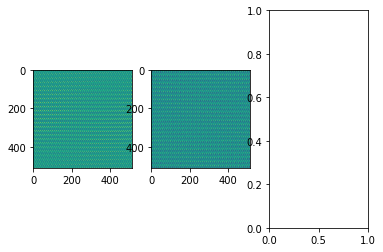

In [35]:
fig, ax = plt.subplots(1, 3)
him0 = ax[0].imshow(np.abs(ORA))
him1 = ax[1].imshow(np.angle(ORA))
#him2 = ax[2].imshow(np.abs(OFTA), norm = colors.LogNorm())

print(rms(OR,ORA))

In [36]:
gradientImage(np.log10(np.abs((fftshift(fft2(np.double(data.camera())))))))

(512, 512)


(array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.35200932, 0.18915195, ..., 0.76798144, 0.57915025,
         0.        ],
        [0.        , 0.330492  , 0.13274446, ..., 0.09839632, 0.81733781,
         0.        ],
        ...,
        [0.        , 0.33227762, 0.3625326 , ..., 0.1650846 , 0.06986488,
         0.        ],
        [0.        , 0.29833672, 0.81733781, ..., 0.03342764, 0.13274446,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.38079315, 0.13675602, ..., 0.1390446 , 1.12153314,
         0.        ],
        [0.        , 0.20017381, 0.32011973, ..., 0.13970205, 0.23791814,
         0.        ],
        ...,
        [0.        , 0.4217248 , 0.59293862, ..., 0.20484546, 0.25433272,
         0.        ],
        [0. 

In [ ]:
findEdge()